# Problem Set 2: Bayes Classifiers
# CMSC422, Fall 2021
# Due Sept 30 at 3:30pm 

<center>
<img src="https://drive.google.com/thumbnail?id=1R2lmx_HWOkuat3X0jolFYDtcZZhZ0jwm&sz=w1000" alt="iq_hist" width="500px"/>
</center>

##Instructions

This iPython notebook contains 3 **programming tasks** to be implemented, as well as 4 **written problems**, which have been enumerated for your convenience.

**Programming tasks:** In this assignment, you will be asked to implement several variations of Bayes classifiers. As these will be autograded, you must provide your solution to these tasks in the provided code blocks marked with **`# your code here`**. There might be some code already provided for you here, and you may add helper functions in the same code block as necessary.

**Written problems:** In addition to programming, you are also given manually-graded analysis questions asking you to interpret results generated by your code (or thereby aid you in doing so).

**Submission instructions:** Download this notebook as a `.ipynb` file and submit it to Gradescope. Please note the following before submitting:
- Make sure your figures (e.g. plots, tables) are visible when downloading the notebook, otherwise they won't appear on Gradescope.
- Make sure your code cells are not throwing exceptions.
- Please do not import any packages other than what has already been imported here. You may be penalized for doing so.


In [1]:
# DO NOT MODIFY THIS BLOCK
# imports and some utility function definitions
import functools
import numpy as np
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# instantiate RNG
prng = np.random.default_rng()

# Plot a 2D decision boundary for a binary classifier implemented by cfunc
# Arguments:
#   cfunc - function implementing the classifier (must take as input a stack of 2-d features, and output a stack of binary classes)
#   feat_range - tuple of tuples, describing the range over the 2-d feature space to visualize
#   colors - colors to label each class as in the plot when fill=True, otherwise the color of the decision boundaries
#   fill - when True, this function fills the regions belonging to each class with the colors; otherwise simply draws the decision boundary
#   line_label - used to assign a label to the decision boundary (so that this shows up in any legend added to the plot)
#   axes - axes object to plot to; if None, simply plots it to the current active axes (will create one if none are available)
def boundplot(cfunc, feat_range=((0,1),(0,1)), colors=['r','b'], fill=True, line_label=None, axes=None):
  [x0, x1] = np.meshgrid(*[np.linspace(l, h, num=64) for (l,h) in feat_range], indexing='ij', sparse=False)
  x = np.stack([x0.ravel(), x1.ravel()], axis=-1)
  y = cfunc(x).reshape(x0.shape)
  if axes:
    if fill:
      contour = axes.contourf(x0,x1,y,levels=[0,0.5,1],colors=colors)
    else:
      contour = axes.contour(x0,x1,y,levels=[0.5],colors=colors,linewidths=1.5)
  else:
    if fill:
      contour = plt.contourf(x0,x1,y,levels=[0,0.5,1],colors=colors)
    else:
      contour = plt.contour(x0,x1,y,levels=[0.5],colors=colors,linewidths=1.5)
    axes = plt.gca()
  axes.set_xlim(feat_range[0])
  axes.set_ylim(feat_range[1])
  axes.set_aspect('equal', adjustable='box')
  if line_label:
    contour.collections[0].set_label(line_label)
  return contour


#0. Numpy Review

As use of [numpy](https://numpy.org/) for the programming tasks is highly advised, this ungraded section provides a quick overview of some numpy basics. For a comprehensive look at the library, see the [documentation](https://numpy.org/doc/stable/contents.html#numpy-docs-mainpage) and [reference manual](https://numpy.org/doc/stable/reference/index.html).

Note that many of the popular machine learning libraries for Python today (e.g. [Tensorflow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/)) implement datatypes with interfaces similar to those of numpy. Hence, it will help to have an understanding of numpy if you plan on using such libraries.


## Numpy Arrays

At the heart of numpy is the $\verb|ndarray|$ object, a container used to represent fixed-size, homogenous, multi-dimensional arrays. The library allows for a variety of mathematical and other operations to be executed on these array objects with high performance and (often) relatively simple code.

For example, suppose we had two 2D arrays $A$ and $B$ of the same dimensions. We would like to compute their element-wise sum: i.e. we want to find an array $C$ of the same dimensions, such that $C_{ij} = A_{ij} + B_{ij}$, where the subscript $_{ij}$ denotes the element at row $i$ and column $j$ of the array.

To do this with Python built-ins, one might write the following code:

In [2]:
A = [[1,2], [3,4], [5,6]]
B = [[7,8], [9,10], [11, 12]]
C = []
for i in range(len(A)):
  c_i = []
  for j in range(len(A[i])):
    c_i.append(A[i][j] + B[i][j])
  C.append(c_i)
C

[[8, 10], [12, 14], [16, 18]]

Or, alternatively, the following one-liner using list comprehension:

In [3]:
[[a_i[0] + b_i[0], a_i[1] + b_i[1]] for a_i, b_i in zip(A,B)]

[[8, 10], [12, 14], [16, 18]]

Using numpy, we can compute the same thing with a very simple line of code:

In [4]:
# convert A, B to ndarrays
A_np = np.array(A)
B_np = np.array(B)
# element-wise addition one-liner; converted back to list for consistent output
(A_np + B_np).tolist()

[[8, 10], [12, 14], [16, 18]]

The best part is, the numpy code above will run much faster than Python built-ins when $A$ and $B$ contain many elements:

In [5]:
import timeit
py_time = timeit.timeit("[[a_i[0] + b_i[0], a_i[1] + b_i[1]] for a_i, b_i in zip(A,B)]",
              setup="A = [[i,i+1] for i in range(0,1000,2)]; B = [[i,i+1] for i in range(1000,2000,2)]",
              number=1000)
np_time = timeit.timeit("A_np + B_np",
              setup="import numpy as np; A_np = np.arange(0,1000).reshape((-1,2)); B_np = np.arange(1000,2000).reshape((-1,2))",
              number=1000)
print("python lists:\n\t{:f}".format(py_time))
print("numpy arrays:\n\t{:f}".format(np_time))

python lists:
	0.134022
numpy arrays:
	0.001037


The benchmark above should show that even on arrays with 1000 elements, the numpy summation is already over an order of magnitude faster.

## Quickstart Tutorial

The [quickstart page](
https://numpy.org/doc/stable/user/quickstart.html) from the official numpy documentation covers everything needed to complete the programing tasks in this assignment. Thus, if you are unfamiliar with numpy, it is highly recommended that you read this page before completing the programming tasks below.

# 1. Naive Bayes Classifier

The goal of this section is to implement a Naive Bayes classifier using the *maximum a posteriori* (MAP) decision rule. That is, given an input $\mathbf{x}$ consisting of $m$ features $(x_0, x_1, \dots, x_{m-1})$ and a set of $k$ output classes $C = \{c_0, c_1, \dots, c_{k-1}\}$, assign $\mathbf{x}$ to the class $\hat{y} \in C$ satisfying:

$$
\hat{y} = \mathop{\mathrm{argmax}}_{c_j \in C} \,\left(P(c_j)\prod_{i=0}^{m-1}P(x_i\mid{}c_j)\right) \tag{1},
$$

where $P(c_j)$ denotes the probability that a data sample belongs to class $c_j$, and $P(x_i\mid{}c_j)$ denotes the probability that a data sample, whose class is $c_j$, has  $x_i$ as its $i$-th feature value. See Section 9.3 of [CIML](http://ciml.info/dl/v0_99/ciml-v0_99-ch09.pdf) for the derivation of the above equation, which is equivalent to Equation 9.18 there.

For the sake of simplicity, in this exercise we will only consider binary classification problems, where $k = 2$.

## 1.1 Categorical Naive Bayes

When the data is categorical, one way of estimating the probabilites in Equation $(1)$ from observed (training) data is to assume that each of the features belonging to a given class follow some generalized Bernoulli distribution. To keep things simple, in this exercise we will only consider binary features (i.e. each feature can only fall into one of two categories, represented as $0$ or $1$).

Thus, to approximate $P(x_i\mid{}c_j)$, let's hypothesize that for all data points with class $j$, the values of their $i$-th feature follow a Bernoulli distribution with parameter $p_{ij}$ (which determines the probability that the feature takes on the value of $1$). Hence, we have:

$$
P(x_i\mid{}c_j) = \begin{cases} 1 - p_{ij} &\text{if } x_i = 0, \\
p_{ij} &\text{otherwise}.\end{cases}
$$

To determine a suitable value of $p_{ij}$ to use, we can use [maximum-likelihood estimation (MLE)](https://mathworld.wolfram.com/MaximumLikelihood.html) based on the training data. For our case, the MLE estimate is simply:

$$
p_{ij} = \frac{count(x_i, c_j)}{count(c_j)},
$$

where $count(c_j)$ is the number of data samples with class $j$, and $count(x_i, c_j)$ is the number of data samples with class $j$ whose $i$-th feature is $x_i$.

Similarly, to approximate $P(c_j)$, we can also suppose that the classes themselves follow a Bernoulli distribution. MLE yields:

$$
P(c_j) = \frac{count(c_j)}{N},
$$

where $N$ is the total number of training samples, and $count(c_j)$ is as above.

It should be mentioned that there is an issue with using the above estimates in practice: some of the probabilities end up becoming 0 if there are no training examples that fall under the corresponding class and feature combinations. This may lead to cases where the expression being maximized in Equation $(1)$ becomes 0 for one, more, or perhaps all hypothesis classes. [Laplace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) is a popluar way to remedy this, but such methods are out of this assignment's scope.

### Programming Task 1 (30 points):

Implement a binary Naive Bayes classifier for categorical data by filling out the class below, using the assumptions above. In particular, the class must implement the $\verb|__init__|$ function and the $\verb|predict|$ function, as detailed below. Do *not* use any smoothing.

The $\verb|__init__|$ function is called when the classifier is initialized, and will be supplied the training data we want the classifier to use.
>Arguments:
>
>* $\verb|features|$: a ndarray of shape $(N,M)$, containing the $M$ feature variables for each of the $N$ training examples. This array has values of $0$ and $1$, corresponding to the two possible categories each feature can take.
>
>* $\verb|labels|$: a ndarray of shape $(N,)$, containing the corresponding labels for each of the $N$ training examples. This array has values of $0$ and $1$, corresponding to the two possible output classes of a binary classification problem.

Once initialized, the $\verb|predict|$ function can then be called to classify new data.

>Arguments:
>
>* $\verb|x|$: a ndarray of shape $(B,M)$, containing the $M$ feature values for each of the $B \geq 1$ new data points. Contains values of $0$ and $1$, corresponding to the two possible categories each feature can take.
>
>Returns:
>
>* A ndarray of shape $(B,)$, containing the predicted output classes of each provided data point. This array should have values of $0$ and $1$, corresponding to the two output classes of a binary classification problem.


In [46]:
class CategoricalNaiveBayes():
  def __init__(self, features, labels):
    # your code here
    self.col_num = features.shape[1]
    self.row_num = len(labels)
    self.num_0 = np.sum(labels == 0)
    self.num_1 = np.sum(labels == 1)
    self.prob_0 = self.num_0/self.row_num
    self.prob_1 = self.num_1/self.row_num
    self.matrix_0 = features[labels == 0]
    self.matrix_1 = features[labels == 1]
    

  def predict(self, x):
    # your code here
    res = []
    for row in x:
      res0 = self.prob_0
      res1 = self.prob_1
      for i in range(self.col_num):
        res0 *= (self.matrix_0[:,i] == row[i]).sum() / self.num_0
        res1 *= (self.matrix_1[:,i] == row[i]).sum() / self.num_1
      
      if res0 >= res1:
        res.append(0)
      else:
        res.append(1)
    return np.array(res)


  # feel free to add any helper functions here

Let's check our implementation against some example data. Consider a dataset with 2 classes $(c_0, c_1)$ and 3 binary features $(x_0, x_1, x_2)$. Suppose we have 100 samples from each class. The data samples can be summarized as the table:

$$
\begin{array}{|c|c|c|c|}
\hline
 & x_0 = 1 & x_1 = 1 & x_2 = 1 \\
\hline
c_0 & 50 & 20 & 80 \\
c_1 & 60 & 70 & 40 \\
\hline
\end{array}
$$

For example, the entry in the "$c_0$" row and "$x_0 = 1$" column denotes that there are 50 samples with class $c_0$ whose $x_0$ feature has value $1$. Since we have 100 samples for each class, there are thus 50 samples with class $c_0$ whose $x_0$ feature has value $0$.

Before running our implementation, let's first find the expected behavior of Naive Bayes on such a dataset by hand. We can then use this to verify the implementation's behavior.

### Written Problem 1 (8 points):

For each of the 8 possible points in the feature space, derive the expected behavior of a Naive Bayes classifier on the dataset described above. As per Equation $(1)$, this involves finding the class $c_j$ that maximizes the following quantity:

$$
score(c_j) = P(c_j)\prod_{i=0}^{2}P(x_i\mid{}c_j) = P(c_j)P(x_0\mid{}c_j)P(x_1\mid{}c_j)P(x_2\mid{}c_j).
$$

To help you get started, the following blank table has been provided below, which can simply be filled out.

*your answer here*

$$
\begin{array}{|c|c|c|c|}
\hline
(x_0,x_1,x_2) & score(c_0) & score(c_1) & \text{output class} \\
\hline
(0,0,0)       &     0.04       &      0.036      &  0                   \\
(0,0,1)       &     0.16       &      0.024      &  0                   \\
(0,1,0)       &     0.01       &      0.084      &  1                   \\
(0,1,1)       &     0.04       &      0.056      &  1                   \\
(1,0,0)       &     0.04       &      0.054      &  1                   \\
(1,0,1)       &     0.16       &      0.036      &  0                   \\
(1,1,0)       &     0.01       &      0.126      &  1                   \\
(1,1,1)       &     0.04       &      0.084      &  1                   \\
\hline
\end{array}
$$

Now, let's compare the expected behavior we've derived with the result of our 

*   List item
*   List item

implementation.

In [47]:
# DO NOT MODIFY THIS BLOCK
seeded = np.random.default_rng(314159) # seeded to ensure deterministic behavior
# generate a dataset conforming to the description above
thresh = [[50, 60], [20, 70], [80, 40]] # the desired sample counts
# for each class, uniformly pick the desired number of samples, assign these features as 1, the rest as 0
x = [[], []]
for thresh_i in thresh:
  x[0].append((seeded.permutation(100) < thresh_i[0]).astype(np.int))
  x[1].append((seeded.permutation(100) < thresh_i[1]).astype(np.int))
# aggregate the two classes, and shuffle the data
x[0] = np.stack(x[0], axis=-1)
x[1] = np.stack(x[1], axis=-1)
x = np.concatenate(x, axis=0)
idx = prng.permutation(x.shape[0])
x = x[idx,...]
y = (np.arange(x.shape[0]) >= 100)[idx]
# set up model
model = CategoricalNaiveBayes(x, y)
# evaluate model for every point in our input space, and arrange it into a table
result_table = np.empty((4,8), dtype=np.int)
for num in range(0,8):
  x_query = np.array([(num >> 2) & 1, (num >> 1) & 1, num & 1])
  result_table[0:3,num] = x_query
  result_table[3,num] = model.predict(np.expand_dims(x_query, axis=0))[0]
result = pandas.DataFrame({'x0' : result_table[0,:], 'x1' : result_table[1,:], 'x2' : result_table[2,:], 'prediction' : result_table[3,:]})
display(HTML(result.to_html(index=False)))

x0,x1,x2,prediction
0,0,0,0
0,0,1,0
0,1,0,1
0,1,1,1
1,0,0,1
1,0,1,0
1,1,0,1
1,1,1,1


Verify that the result is as expected.

### Written Problem 2 (6 points):

Suppose the features in the data above are indeed independent, and that the Bernoulli distributions we used to approximate $P(x_i\mid{}c_j)$ and $P(c_j)$ fit the true data distribution exactly. What is the classification error rate for our Naive Bayes classifier?

*your answer here*

In [8]:
0.036+0.024+0.01+0.04+0.04+0.036+0.01+0.04

0.23600000000000002

The classification error rate is 0.236.

## 1.2 Gaussian Naive Bayes

When dealing with continuous, numerical data, we might instead estimate the relevant probabilities in Equation $(1)$ by assuming that each of the features belonging to a given class follow some normal (Gaussian) distribution. Thus, we can then use the corresponding probability density function to approximate the probability $P(x_i\mid{}c_j)$ for feature $i$ and class $j$, as follows:

$$
P(x_i\mid{}c_j) = \frac{1}{\sigma_{ij}\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x_i - \mu_{ij}}{\sigma_{ij}}\right)^2},
$$

where $\mu_{ij}, \sigma_{ij}$ are the mean and standard deviation of feature $i$ conditioned class $j$. The [MLE estimates for a Gaussian distribution](https://mathworld.wolfram.com/MaximumLikelihood.html) are simply the sample mean and deviation of training samples with class $j$.

Since the classes themselves remain categorical, we can still estimate $P(c_j)$ with a Bernoulli distribution, as was done previously.


### Programming Task 2 (30 points):

Implement a binary Naive Bayes classifier for continuous data by filling out the class below. As in Problem 1, the class must implement the $\verb|__init__|$ function and the $\verb|predict|$ function, as detailed below.

The $\verb|__init__|$ function is called when the classifier is initialized, and will be supplied the training data we want the classifier to use.
>Arguments:
>
>* $\verb|features|$: a ndarray of shape $(N,M)$, containing the $M$ feature variables for each of the $N$ training examples.
>
>* $\verb|labels|$: a ndarray of shape $(N,)$, containing the corresponding labels for each of the $N$ training examples. This array has values of $0$ and $1$, corresponding to the two possible output classes of a binary classification problem.

Once initialized, the $\verb|predict|$ function can then be called to classify new data.

>Arguments:
>
>* $\verb|x|$: a ndarray of shape $(B,M)$, containing the feature values of $B \geq 1$ new data points.
>
>Returns:
>
>* A ndarray of shape $(B,)$, containing the predicted output classes of each provided data point. This array should have values of $0$ and $1$, corresponding to the two output classes of a binary classification problem.


In [74]:
class GaussianNaiveBayes():
  def __init__(self, features, labels):
    # your code here
    self.col_num = features.shape[1]
    self.row_num = len(labels)
    self.num_0 = np.sum(labels == 0)
    self.num_1 = np.sum(labels == 1)
    self.prob_0 = self.num_0/self.row_num
    self.prob_1 = self.num_1/self.row_num
    self.matrix_0 = features[labels == 0]
    self.matrix_1 = features[labels == 1]
    

  def predict(self, x):
    # your code here
    res = []
    for row in x:
      res0 = 1
      res1 = 1
      for i in range(self.col_num):
        mean_0 = np.mean(self.matrix_0[:,i], 0)
        std_0 = np.std(self.matrix_0[:,i], 0)
        res0 *= (np.exp(-(1/2) * ((row[i] - mean_0)/std_0)**2))/(np.sqrt(2 * np.pi) * std_0)
        
        mean_1 = np.mean(self.matrix_1[:,i], 0)
        std_1 = np.std(self.matrix_1[:,i], 0)
        res1 *= (np.exp(-1/2 * ((row[i] - mean_1)/std_1)**2))/(np.sqrt(2 * np.pi) * std_1)
      
      if res0 >= res1:
        res.append(0)
      else:
        res.append(1)
    return np.array(res)

  # feel free to add any helper functions here

Let's test the implementation on some example data.

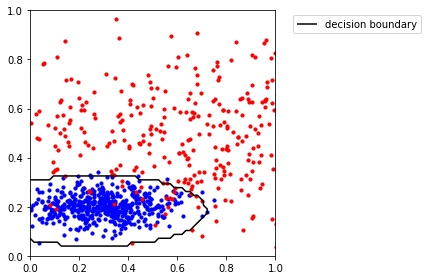

In [75]:
# DO NOT MODIFY THIS BLOCK
# draw samples from two classes that are each gaussian-distributed
x_0 = prng.multivariate_normal([0.3,0.2], np.square(np.array([[0.15,0],[0,0.05]])), size=(512,))
x_1 = prng.multivariate_normal([0.8,0.5], np.square(np.array([[0.6,0],[0,0.2]])), size=(512,))
# display the samples
ax = plt.axes()
ax.scatter(x_0[...,0], x_0[...,1], s=10, c='b')
ax.scatter(x_1[...,0], x_1[...,1], s=10, c='r')
# create our data array: aggregate the classes' samples and shuffle
x = np.concatenate([x_0, x_1], axis=0)
y = (np.arange(x.shape[0]) < 512)
idx = prng.permutation(x.shape[0])
x = x[idx,...]
y = y[idx]
# set up model and plot its decision boundary
model = GaussianNaiveBayes(x ,y)
boundplot(lambda x : model.predict(x), colors=['k'], fill=False, line_label='decision boundary', axes=ax)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

As a sanity check for yourself, make sure that the decision boundary shown above is sensible.

Now let's see how well our Gaussian-prior classifier works on data that does not meet our prior assumptions. For simplicity, let's define our data such that our two classes are uniformly distributed in mutually exclusive areas in the feature space.

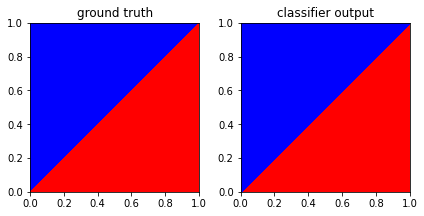

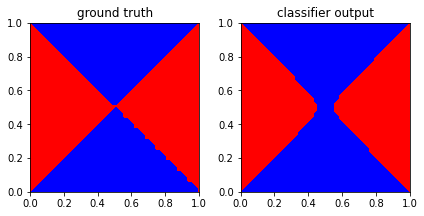

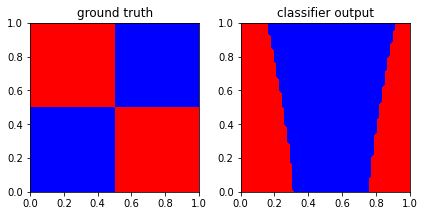

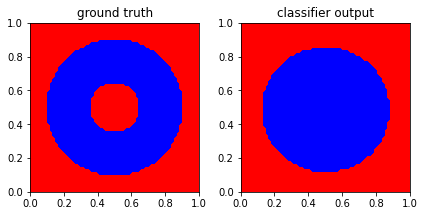

In [76]:
# DO NOT MODIFY THIS BLOCK
# four datasets in which the ground-truth class for each point in our feature space
# (which is simply the unit square) is determined by the labelfuncs below
x = prng.uniform(0.0,1.0,size=(4096,2))
labelfuncs = [lambda x : (x[...,0] < x[...,1]),
              lambda x : (np.abs(x[...,0] - 0.5) < np.abs(x[...,1] - 0.5)),
              lambda x : ((x[...,0] < 0.5) * (x[...,1] < 0.5) + (x[...,0] > 0.5) * (x[...,1] > 0.5)),
              lambda x : ((np.sqrt(np.sum(np.square(x - 0.5), axis=-1)) > 0.15) * (np.sqrt(np.sum(np.square(x - 0.5), axis=-1)) < 0.4))]

for labelfunc in labelfuncs:
  # apply the ground-truth labels for this dataset
  y = labelfunc(x)
  # plot and compare the ground-truth distribution and model output
  _, axarr = plt.subplots(1,2)
  # ground-truth
  boundplot(labelfunc, axes=axarr[0])
  axarr[0].set_title('ground truth')
  # our model
  model = GaussianNaiveBayes(x, y)
  boundplot(lambda x : model.predict(x), fill=True, axes=axarr[1])
  axarr[1].set_title('classifier output')
  plt.tight_layout()


### Written Problem 3 (8 points):

How well does the classifier perform in these cases? Why do you think the classifier behaves the way it does in each of the four cases?

*your answer here*

The classfier performs better in continuous data which is the first example, and it performs not so well in others example. This is because it uses mean and standard deviation in these cases, and whether it is continuous is pretty important and will affect their performance.

# 2. Bayes Optimal Classifier

Recall that the Naive Bayes formulation shown in Equation $(1)$ is a simplification for that of the Bayes optimal classifier:

$$
\hat{y} = \mathop{\mathrm{argmax}}_{c_j \in C} \,\left(P(c_j)P(\mathbf{x}\mid{}c_j)\right) \tag{2},
$$

where $\mathbf{x} = (x_0, x_1, \dots, x_{m-1})$ are the features of an input sample, $C = \{c_0, c_1, \dots, c_{k-1}\}$ are the output classes, and $P(\mathbf{x}\mid{}c_j)$ is the joint probability density for all features, conditioned on class $c_j$ and evaluated at $\mathbf{x}$.

Of course, we typically don't know $P(\mathbf{x}\mid{}c_j)$ in practice, and estimating it is often intractable for the complex datasets found in the wild. Nonetheless, it can be useful as a benchmark to compare a practical classifier with the Bayes optimal on a synthetic dataset (for which $P(\mathbf{x}\mid{}c_j)$ is known).

### Programming Task 3 (10 points):

Implement a binary Bayes Optimal classifier for continuous data by filling out the class below. Conforming to the previous classifier implementations, the class must implement the $\verb|__init__|$ function and the $\verb|predict|$ function, as detailed below.

The $\verb|__init__|$ function is called when the classifier is initialized, and will be supplied the probability density functions we want the classifier to use.
>Arguments:
>
>* $\verb|pdf_0|$, $\verb|pdf_1|$: functions that, when called, return the probability density of the corresponding class evaluated at a query point. Each function takes as input a ndarray of shape $(B,M)$, consisting of $B \geq 1$ query points in the $M$-dimensional feature space, and outputs a ndarray of shape $(B,)$ containing the corresponding probability densities.
>
>* $\verb|prob_0|$: the class prior probability for the first class (i.e. $P(c_0)$). Note that this also implicitly determines the prior probability for the second class, as they must sum to $1$. Will always be in range $[0,1]$.

Once initialized, the $\verb|predict|$ function can then be called to classify new data.

>Arguments:
>
>* $\verb|x|$: a ndarray of shape $(B,M)$, containing the feature values of $B \geq 1$ new data points.
>
>Returns:
>
>* A ndarray of shape $(B,)$, containing the predicted output classes of each provided data point. This array should have values of $0$ and $1$, corresponding to the two output classes of a binary classification problem.


In [77]:
class BayesOptimal():
  def __init__(self, pdf_0, pdf_1, prob_0):
    # your code here
    self.pdf_0 = pdf_0
    self.pdf_1 = pdf_1
    self.prob_0 = prob_0
    self.prob_1 = 1 - prob_0

  def predict(self, x):
    # your code here
    res = []
    for i in range(0, len(x)):
      res0 = 0
      res1 = 0
      res0 = self.prob_0 * self.pdf_0(x[i])
      res1 = self.prob_1 * self.pdf_1(x[i])
        
      if res0 > res1:
        res.append(0)
      else:
        res.append(1)
    return np.array(res)
    
  # feel free to add any helper functions here

Let's test our Bayes optimal classifier on some correlated, Gaussian-distributed data, and compare it to our Gaussian Naive Bayes classifier.

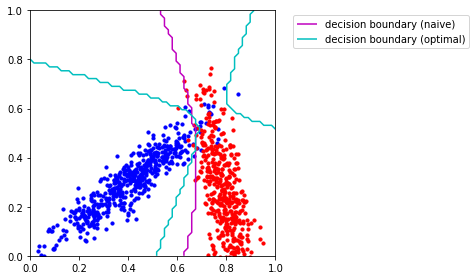

In [78]:
# DO NOT MODIFY THIS BLOCK
import scipy.stats
from scipy.stats import multivariate_normal as mvn
# the parameters for our example data distribution (mean and covariance)
mean_0 = np.array([0.4,0.3])
mean_1 = np.array([0.8,0.2])
cov_0 = np.array([[200,150],[150,140]])/10000
cov_1 = np.array([[40,-100],[-100,500]])/10000
# draw samples from the distributions
x_0 = prng.multivariate_normal(mean_0, cov_0, size=(512,))
x_1 = prng.multivariate_normal(mean_1, cov_1, size=(512,))
# plot drawn samples
ax = plt.axes()
ax.scatter(x_0[...,0], x_0[...,1], s=10, c='b')
ax.scatter(x_1[...,0], x_1[...,1], s=10, c='r')
# aggregate classes, shuffle
x = np.concatenate([x_0, x_1], axis=0)
y = (np.arange(x.shape[0]) < 512)
idx = prng.permutation(x.shape[0])
x = x[idx,...]
y = y[idx]
# set up models and plot their decision boundaries
model_naive = GaussianNaiveBayes(x, y)
model_opt = BayesOptimal(functools.partial(mvn.pdf, mean=mean_0, cov=cov_0), functools.partial(mvn.pdf, mean=mean_1, cov=cov_1), 0.5)
boundplot(lambda x : model_naive.predict(x), colors=['m'], fill=False, line_label='decision boundary (naive)', axes=ax)
boundplot(lambda x : model_opt.predict(x), colors=['c'], fill=False, line_label='decision boundary (optimal)', axes=ax)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

### Written Problem 4 (8 points):

Which classifier performs better here? Why? Under what circumstances, if any, would the two classifiers perform equally well? Which one do you think will work better in most of the real-life scenarios and why ?

*your answer here*

I think optimal classifier performs better here, because it choose the class greatest probability of occurence. When the data are independent, the two classifier perform equally well. I think the optimal classifier will perform better in real-life scenarios, because probability functions more in line with real life, but we still need to think about the actual runtime and memory.